In [1]:
!pip install torchinfo

In [2]:
!pip install gdown

In [3]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau


import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
import matplotlib.pyplot as plt

import os

In [4]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 모델 가중치 저장 경로 설정
model_weight_path = "./model_weights.pth"

In [5]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [6]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [7]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [8]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [9]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [10]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [11]:
#CNNDownSample 적용
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [12]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [13]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [14]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x


In [15]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=100):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [16]:
model = LevitDistilled()
# model = LauncherModel()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 1e-4
num_epochs = 50

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [17]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 100]                 --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [18]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 100]                 --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [19]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [20]:
train_data = datasets.CIFAR100(root="data", train=True, transform=transform, download=True)
test_data = datasets.CIFAR100(root="data", train=False, transform=transform, download=True)
combined_data = ConcatDataset([train_data, test_data])

train_size = int(0.7 * len(combined_data))
val_size = int(0.15 * len(combined_data))
test_size = len(combined_data) - train_size - val_size
train_data, val_data, test_data = random_split(combined_data, [train_size, val_size, test_size])

100%|██████████| 169M/169M [00:13<00:00, 12.5MB/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [21]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 42000
Validation size: 9000
Test size: 9000


In [28]:

# Import necessary libraries for training
import torch.optim as optim
import torch.nn as nn


criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)




/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [26]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

In [23]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    if phase == "Validation":
        val_losses.append(epoch_loss)
        val_accuracies.append(accuracy)
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")

In [24]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [29]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")
    val_loss = val_losses[-1]  # Assuming `val_losses` is updated in `evaluate`
    scheduler.step(val_loss)
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.8f}")


Epoch 1/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 4.0731, Train Accuracy: 8.56%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 3.9358, Validation Accuracy: 11.01%
Learning Rate: 0.00010000

Epoch 2/50


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 3.8959, Train Accuracy: 10.97%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 3.7690, Validation Accuracy: 13.21%
Learning Rate: 0.00010000

Epoch 3/50


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 3.7641, Train Accuracy: 12.73%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 3.6423, Validation Accuracy: 15.06%
Learning Rate: 0.00010000

Epoch 4/50


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 3.6366, Train Accuracy: 14.66%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.81it/s]


Validation Loss: 3.5338, Validation Accuracy: 16.43%
Learning Rate: 0.00010000

Epoch 5/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 3.5271, Train Accuracy: 16.67%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 3.4561, Validation Accuracy: 17.80%
Learning Rate: 0.00010000

Epoch 6/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 3.4268, Train Accuracy: 18.34%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.74it/s]


Validation Loss: 3.3428, Validation Accuracy: 20.33%
Learning Rate: 0.00010000

Epoch 7/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.12it/s]


Train Loss: 3.3327, Train Accuracy: 20.21%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 3.2693, Validation Accuracy: 21.23%
Learning Rate: 0.00010000

Epoch 8/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 3.2402, Train Accuracy: 21.99%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.47it/s]


Validation Loss: 3.1701, Validation Accuracy: 23.44%
Learning Rate: 0.00010000

Epoch 9/50


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 3.1593, Train Accuracy: 23.68%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.69it/s]


Validation Loss: 3.1196, Validation Accuracy: 23.72%
Learning Rate: 0.00010000

Epoch 10/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 3.0879, Train Accuracy: 24.86%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.53it/s]


Validation Loss: 3.0524, Validation Accuracy: 25.74%
Learning Rate: 0.00010000

Epoch 11/50


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 3.0240, Train Accuracy: 25.96%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 3.0003, Validation Accuracy: 26.37%
Learning Rate: 0.00010000

Epoch 12/50


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.9645, Train Accuracy: 27.01%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.9351, Validation Accuracy: 28.02%
Learning Rate: 0.00010000

Epoch 13/50


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 2.9046, Train Accuracy: 28.26%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.9219, Validation Accuracy: 28.20%
Learning Rate: 0.00010000

Epoch 14/50


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 2.8544, Train Accuracy: 29.45%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.83it/s]


Validation Loss: 2.8748, Validation Accuracy: 28.49%
Learning Rate: 0.00010000

Epoch 15/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 2.8027, Train Accuracy: 30.09%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.53it/s]


Validation Loss: 2.8278, Validation Accuracy: 29.97%
Learning Rate: 0.00010000

Epoch 16/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.7612, Train Accuracy: 31.08%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 2.8296, Validation Accuracy: 29.47%
Learning Rate: 0.00010000

Epoch 17/50


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 2.7174, Train Accuracy: 31.87%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.70it/s]


Validation Loss: 2.7797, Validation Accuracy: 31.01%
Learning Rate: 0.00010000

Epoch 18/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.6745, Train Accuracy: 32.65%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 2.7490, Validation Accuracy: 32.16%
Learning Rate: 0.00010000

Epoch 19/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.6304, Train Accuracy: 33.55%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.7190, Validation Accuracy: 32.48%
Learning Rate: 0.00010000

Epoch 20/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.5951, Train Accuracy: 34.24%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 2.6895, Validation Accuracy: 32.78%
Learning Rate: 0.00010000

Epoch 21/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.5444, Train Accuracy: 35.48%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.6817, Validation Accuracy: 33.28%
Learning Rate: 0.00010000

Epoch 22/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.5179, Train Accuracy: 36.30%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.6386, Validation Accuracy: 33.90%
Learning Rate: 0.00010000

Epoch 23/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.4772, Train Accuracy: 36.79%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.45it/s]


Validation Loss: 2.6105, Validation Accuracy: 34.08%
Learning Rate: 0.00010000

Epoch 24/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.12it/s]


Train Loss: 2.4394, Train Accuracy: 37.38%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.41it/s]


Validation Loss: 2.6122, Validation Accuracy: 34.59%
Learning Rate: 0.00010000

Epoch 25/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.12it/s]


Train Loss: 2.4092, Train Accuracy: 38.16%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.63it/s]


Validation Loss: 2.5796, Validation Accuracy: 34.90%
Learning Rate: 0.00010000

Epoch 26/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.3688, Train Accuracy: 38.84%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.46it/s]


Validation Loss: 2.5688, Validation Accuracy: 35.41%
Learning Rate: 0.00010000

Epoch 27/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.3292, Train Accuracy: 40.04%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.75it/s]


Validation Loss: 2.5398, Validation Accuracy: 35.89%
Learning Rate: 0.00010000

Epoch 28/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 2.3051, Train Accuracy: 40.35%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.41it/s]


Validation Loss: 2.5355, Validation Accuracy: 36.02%
Learning Rate: 0.00010000

Epoch 29/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 2.2714, Train Accuracy: 40.96%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.55it/s]


Validation Loss: 2.5255, Validation Accuracy: 36.06%
Learning Rate: 0.00010000

Epoch 30/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 2.2433, Train Accuracy: 41.84%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.4879, Validation Accuracy: 37.12%
Learning Rate: 0.00010000

Epoch 31/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 2.2092, Train Accuracy: 42.57%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.4908, Validation Accuracy: 37.08%
Learning Rate: 0.00010000

Epoch 32/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 2.1872, Train Accuracy: 42.94%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.50it/s]


Validation Loss: 2.4540, Validation Accuracy: 38.03%
Learning Rate: 0.00010000

Epoch 33/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.1431, Train Accuracy: 43.92%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 2.4672, Validation Accuracy: 38.02%
Learning Rate: 0.00010000

Epoch 34/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


Train Loss: 2.1205, Train Accuracy: 44.39%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.55it/s]


Validation Loss: 2.4303, Validation Accuracy: 38.39%
Learning Rate: 0.00010000

Epoch 35/50


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.95it/s]


Train Loss: 2.0827, Train Accuracy: 45.36%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.45it/s]


Validation Loss: 2.4286, Validation Accuracy: 38.78%
Learning Rate: 0.00010000

Epoch 36/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 2.0605, Train Accuracy: 45.72%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.45it/s]


Validation Loss: 2.4212, Validation Accuracy: 39.21%
Learning Rate: 0.00010000

Epoch 37/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.98it/s]


Train Loss: 2.0286, Train Accuracy: 46.67%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.59it/s]


Validation Loss: 2.4090, Validation Accuracy: 39.31%
Learning Rate: 0.00010000

Epoch 38/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.0005, Train Accuracy: 47.42%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.52it/s]


Validation Loss: 2.3912, Validation Accuracy: 39.36%
Learning Rate: 0.00010000

Epoch 39/50


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.9692, Train Accuracy: 47.88%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 2.3738, Validation Accuracy: 40.22%
Learning Rate: 0.00010000

Epoch 40/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 1.9490, Train Accuracy: 48.37%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.30it/s]


Validation Loss: 2.3878, Validation Accuracy: 39.51%
Learning Rate: 0.00010000

Epoch 41/50


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.9155, Train Accuracy: 48.95%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 2.3654, Validation Accuracy: 40.06%
Learning Rate: 0.00010000

Epoch 42/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 1.8921, Train Accuracy: 49.48%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 2.3482, Validation Accuracy: 40.80%
Learning Rate: 0.00010000

Epoch 43/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 1.8624, Train Accuracy: 50.20%


Validation: 100%|██████████| 282/282 [00:16<00:00, 16.99it/s]


Validation Loss: 2.3634, Validation Accuracy: 40.58%
Learning Rate: 0.00010000

Epoch 44/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 1.8415, Train Accuracy: 50.65%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.41it/s]


Validation Loss: 2.3296, Validation Accuracy: 41.11%
Learning Rate: 0.00010000

Epoch 45/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 1.8207, Train Accuracy: 51.14%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.75it/s]


Validation Loss: 2.3179, Validation Accuracy: 41.13%
Learning Rate: 0.00010000

Epoch 46/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.7873, Train Accuracy: 51.97%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.31it/s]


Validation Loss: 2.3370, Validation Accuracy: 41.44%
Learning Rate: 0.00010000

Epoch 47/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 1.7629, Train Accuracy: 52.81%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.60it/s]


Validation Loss: 2.3331, Validation Accuracy: 41.33%
Learning Rate: 0.00010000

Epoch 48/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 1.7331, Train Accuracy: 53.30%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.51it/s]


Validation Loss: 2.3479, Validation Accuracy: 40.97%
Learning Rate: 0.00010000

Epoch 49/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 1.7119, Train Accuracy: 53.81%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 2.3133, Validation Accuracy: 41.63%
Learning Rate: 0.00010000

Epoch 50/50


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 1.6834, Train Accuracy: 54.38%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]

Validation Loss: 2.3116, Validation Accuracy: 41.80%
Learning Rate: 0.00010000


In [30]:
print("\nFinal Test Evaluation")
evaluate(model, test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]

Test Loss: 2.3093, Test Accuracy: 42.64%


In [31]:
import torch
torch.save(model.state_dict(), model_weight_path)
print(f"Model weights saved to {model_weight_path}")

Model weights saved to ./model_weights.pth


In [32]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 282
Average Time: 5.82 ms
Standard Deviation: 0.31 ms
Maximum Time: 7.65 ms
Minimum Time: 5.21 ms


In [33]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         2.05%     362.531us        17.47%       3.085ms     128.559us       0.000us         0.00%       2.530ms     105.413us            24  
                                           aten::linear         0.48%      85.359us        12.63%       2.231ms     123.942us       0.000us         0.00%       1.823ms     101.287us            18  
         

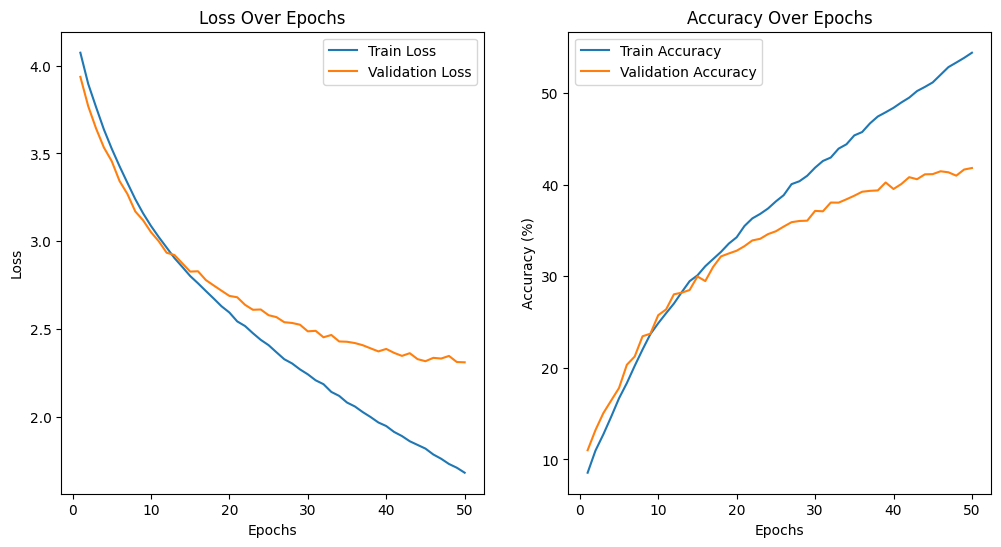

In [34]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()